## Import required libraries.

In [2]:
import nltk
import torch
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import torch.nn as nn
import tensorflow as tf
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from torch.utils.data import DataLoader, Dataset, random_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score, f1_score

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
# Load Amazon food review dataset
df = pd.read_csv('/kaggle/input/amazon-fine-food-review/Reviews.csv')

# Basic data exploration
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...
568453,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,5,1338422400,Great Honey,"I am very satisfied ,product is as advertised,..."


In [5]:
df.shape

(568454, 10)

#### Basic data exploration.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
df.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [8]:
df.isna()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
568449,False,False,False,False,False,False,False,False,False,False
568450,False,False,False,False,False,False,False,False,False,False
568451,False,False,False,False,False,False,False,False,False,False
568452,False,False,False,False,False,False,False,False,False,False


In [9]:
df.value_counts().sum()

568401

In [10]:
df.nunique()

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218415
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295742
Text                      393579
dtype: int64

In [11]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


#### Plot Distribution

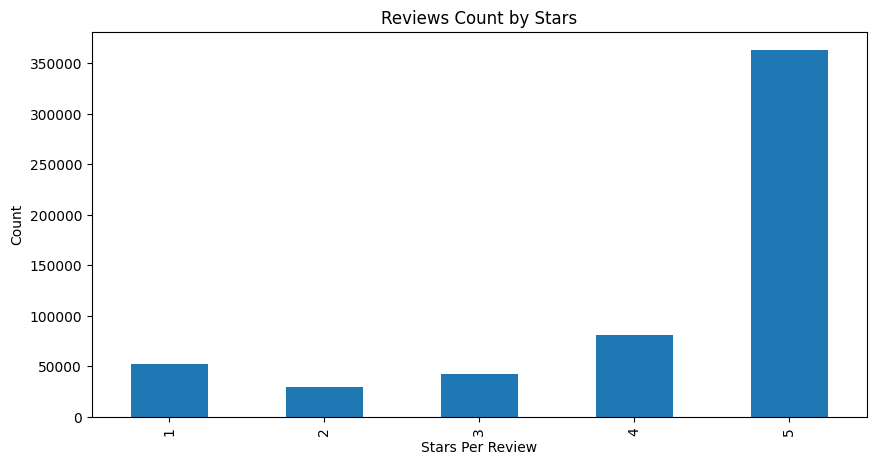

In [12]:
# Checking the distribution of review ratings
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='Reviews Count by Stars', figsize=(10, 5))
ax.set_xlabel('Stars Per Review')
ax.set_ylabel('Count')

plt.show()

### Basic NLTK

In [13]:
example = df['Text'][88]

example

"Natural Balance Dry Dog Food Lamb Meal and Brown Rice Recipe did wonders for my Jack Russell. She has awful food allergy's and this food was our last hope because it was the last food we could find that didn't have SOMETHING in it that she was allergic to. She has no problem eating it dry but normally I mix the Natural Balance Dry Lamb and Brown Rice with the Natural Balance Wet Lamb and Brown Rice.. she seems to like that better. We started feeding it to our other dog (a Bichon) too and she loves it. If your dog has allergy's or stomach issue.. or if you want your dog to eat better food-- this is it! You will see a difference in your pet."

In [14]:
token = nltk.word_tokenize(example)
token[:15]

['Natural',
 'Balance',
 'Dry',
 'Dog',
 'Food',
 'Lamb',
 'Meal',
 'and',
 'Brown',
 'Rice',
 'Recipe',
 'did',
 'wonders',
 'for',
 'my']

In [15]:
tag = nltk.pos_tag(token)
tag[:20]

[('Natural', 'JJ'),
 ('Balance', 'NNP'),
 ('Dry', 'NNP'),
 ('Dog', 'NNP'),
 ('Food', 'NNP'),
 ('Lamb', 'NNP'),
 ('Meal', 'NNP'),
 ('and', 'CC'),
 ('Brown', 'NNP'),
 ('Rice', 'NNP'),
 ('Recipe', 'NNP'),
 ('did', 'VBD'),
 ('wonders', 'NNS'),
 ('for', 'IN'),
 ('my', 'PRP$'),
 ('Jack', 'NNP'),
 ('Russell', 'NNP'),
 ('.', '.'),
 ('She', 'PRP'),
 ('has', 'VBZ')]

In [16]:
entities = nltk.chunk.ne_chunk(tag)
entities.pprint()

(S
  Natural/JJ
  (ORGANIZATION
    Balance/NNP
    Dry/NNP
    Dog/NNP
    Food/NNP
    Lamb/NNP
    Meal/NNP)
  and/CC
  (PERSON Brown/NNP Rice/NNP Recipe/NNP)
  did/VBD
  wonders/NNS
  for/IN
  my/PRP$
  (PERSON Jack/NNP Russell/NNP)
  ./.
  She/PRP
  has/VBZ
  awful/JJ
  food/NN
  allergy/NN
  's/POS
  and/CC
  this/DT
  food/NN
  was/VBD
  our/PRP$
  last/JJ
  hope/NN
  because/IN
  it/PRP
  was/VBD
  the/DT
  last/JJ
  food/NN
  we/PRP
  could/MD
  find/VB
  that/DT
  did/VBD
  n't/RB
  have/VB
  SOMETHING/VBN
  in/IN
  it/PRP
  that/IN
  she/PRP
  was/VBD
  allergic/JJ
  to/TO
  ./.
  She/PRP
  has/VBZ
  no/DT
  problem/NN
  eating/VBG
  it/PRP
  dry/JJ
  but/CC
  normally/RB
  I/PRP
  mix/VBP
  the/DT
  (ORGANIZATION Natural/NNP Balance/NNP Dry/NNP Lamb/NNP)
  and/CC
  (PERSON Brown/NNP Rice/NNP)
  with/IN
  the/DT
  (ORGANIZATION Natural/NNP Balance/NNP Wet/NNP Lamb/NNP)
  and/CC
  (PERSON Brown/NNP)
  Rice../NNP
  she/PRP
  seems/VBZ
  to/TO
  like/VB
  that/DT
  better/JJR
 

### Check polarity score of the example.

In [17]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(example)

{'neg': 0.048, 'neu': 0.762, 'pos': 0.19, 'compound': 0.9716}

### Run polarity score on the entire dataset.

In [18]:
class VaderSentimentAnalyzer:
    """
    A class to analyze sentiment using NLTK's VADER sentiment analyzer.

    Attributes:
    -----------
    sia : SentimentIntensityAnalyzer
        An instance of the SentimentIntensityAnalyzer from NLTK.
    """

    def __init__(self):
        """
        Initializes the VaderSentimentAnalyzer by loading the VADER lexicon and
        creating an instance of the SentimentIntensityAnalyzer.
        """
        nltk.download('vader_lexicon', quiet=True)
        self.sia = SentimentIntensityAnalyzer()

    def analyze(self, text):
        """
        Analyze the sentiment of a given text and return a sentiment label.

        Parameters:
        -----------
        text : str
            Text for sentiment analysis.

        Returns:
        --------
        str
            Sentiment label ('positive', 'neutral', 'negative') based on compound score.
        """
        score = self.sia.polarity_scores(text)['compound']
        if score >= 0.05:
            return 'positive'
        elif score <= -0.05:
            return 'negative'
        else:
            return 'neutral'


class ScoreConverter:
    """
    A class to convert integer score values (1 to 5) to sentiment labels.

    Methods:
    --------
    convert(score: int) -> str:
        Converts a numeric score into a sentiment label ('positive', 'neutral', or 'negative').
    """

    @staticmethod
    def convert(score):
        """
        Convert a numeric score into a sentiment label.

        Parameters:
        -----------
        score : int
            An integer score between 1 and 5.

        Returns:
        --------
        str
            Corresponding sentiment label ('positive', 'neutral', 'negative').
        """
        if score >= 4:
            return 'positive'
        elif score <= 2:
            return 'negative'
        else:
            return 'neutral'


class SentimentEvaluator:
    """
    A class to handle sentiment analysis evaluation using different models and batch processing.

    Attributes:
    -----------
    model : object
        A sentiment analysis model (e.g., VaderSentimentAnalyzer) with an analyze method.
    batch_size : int
        The size of each batch for processing large datasets.
    """

    def __init__(self, model, batch_size=1000):
        """
        Initializes the SentimentEvaluator with a model and batch size.

        Parameters:
        -----------
        model : object
            A sentiment analysis model that has an 'analyze' method.
        batch_size : int, optional
            Number of rows to process in each batch, by default 1000.
        """
        self.model = model
        self.batch_size = batch_size

    def evaluate(self, df, text_column, score_column):
        """
        Evaluates the model's performance on a dataset in batches.

        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame containing the dataset with text and score columns.
        text_column : str
            Name of the column containing text to be analyzed.
        score_column : str
            Name of the column containing integer sentiment scores (1-5).

        Returns:
        --------
        None
            Prints the classification report.
        """
        predictions = []
        actual_labels = df[score_column].apply(ScoreConverter.convert).tolist()

        # Process data in batches to save memory
        for start in tqdm(range(0, len(df), self.batch_size), desc="Processing Batches"):
            batch_texts = df[text_column].iloc[start:start+self.batch_size].tolist()
            batch_preds = [self.model.analyze(text) for text in batch_texts]
            predictions.extend(batch_preds)

        # Generate and print classification report
        print("Classification Report:")
        print(classification_report(actual_labels, predictions, target_names=['negative', 'neutral', 'positive']))

        # Get the accuracy of the model.
        acc = accuracy_score(actual_labels, predictions)
        print("Accuracy:", acc)

        return acc


# `df` has a 'Text' column with reviews and 'Score' column with ratings (1 to 5)

vader = VaderSentimentAnalyzer()
se = SentimentEvaluator(model=vader, batch_size=500)
se.evaluate(df, text_column='Text', score_column='Score')

Processing Batches: 100%|██████████| 1137/1137 [06:54<00:00,  2.74it/s]


Classification Report:
              precision    recall  f1-score   support

    negative       0.55      0.39      0.46     82037
     neutral       0.13      0.04      0.06     42640
    positive       0.84      0.94      0.89    443777

    accuracy                           0.80    568454
   macro avg       0.51      0.46      0.47    568454
weighted avg       0.75      0.80      0.76    568454

Accuracy: 0.7956228648228353


0.7956228648228353

In [19]:
vader_accuracy = se.evaluate(df, text_column='Text', score_column='Score')

Processing Batches: 100%|██████████| 1137/1137 [06:54<00:00,  2.74it/s]


Classification Report:
              precision    recall  f1-score   support

    negative       0.55      0.39      0.46     82037
     neutral       0.13      0.04      0.06     42640
    positive       0.84      0.94      0.89    443777

    accuracy                           0.80    568454
   macro avg       0.51      0.46      0.47    568454
weighted avg       0.75      0.80      0.76    568454

Accuracy: 0.7956228648228353


# Tensorflow Model Creation And Training.

In [20]:
x_train, x_temp, y_train, y_temp = train_test_split(df['Text'], df['Score'], test_size=.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=.5, random_state=42)

# Parameters
vocab_size = 5000
embedding_dim = 32
max_len = 100  # Maximum length for padding

# Tokenize and sequence the text
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

x_train_seq = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=max_len, padding='post', truncating='post')
x_val_seq = pad_sequences(tokenizer.texts_to_sequences(x_val), maxlen=max_len, padding='post', truncating='post')
x_test_seq = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=max_len, padding='post', truncating='post')

class TensorFlowSentimentModel:
    """
    A TensorFlow-based neural network model for sentiment classification.

    This class creates a Sequential model with an embedding layer, 
    a global average pooling layer, and two dense layers for classification. 
    The model is designed to classify sentiment into three classes.

    Attributes:
    -----------
    model : tf.keras.Sequential
        A TensorFlow sequential model with embedding, pooling, and dense layers.
    """
    
    def __init__(self, vocab_size, embedding_dim):
        """
        Initializes the TensorFlow sentiment analysis model with an embedding layer and dense layers.

        Parameters:
        -----------
        vocab_size : int
            The size of the vocabulary used for embedding.
        embedding_dim : int
            The dimension of the embedding space.
        max_len : int
            The maximum length of input sequences.
        """
        self.model = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(3, activation='softmax')  # Three output classes: positive, negative, neutral
        ])
        
        # Compile model with optimizer, loss, and metrics
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    def train(self, x_train, x_text, x_val, y_val, log_dir):
        """
        Trains the TensorFlow model using provided training and validation data.

        Parameters:
        -----------
        train_data : array-like
            Training data samples.
        train_labels : array-like
            Labels for the training data.
        val_data : array-like
            Validation data samples.
        val_labels : array-like
            Labels for the validation data.
        log_dir : str
            Directory path to save TensorBoard logs.
        """
        # TensorBoard callback for monitoring model performance
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
        
        # Fit model with training and validation data
        history = self.model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks=[tensorboard_callback])
        
        return history
        
# Map the scores to three classes
def map_score_to_class(score):
    if score <= 2:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

# Apply mapping to y_train, y_val, y_test
y_train = np.array([map_score_to_class(score) for score in y_train])
y_val = np.array([map_score_to_class(score) for score in y_val])
y_test = np.array([map_score_to_class(score) for score in y_test])

# Initialize and train the model
tfModel = TensorFlowSentimentModel(vocab_size=vocab_size, embedding_dim=embedding_dim)
history = tfModel.train(x_train_seq, y_train, x_val_seq, y_val, log_dir='logs/tensorflow')

Epoch 1/10


I0000 00:00:1749996791.287399     101 service.cc:145] XLA service 0x7df448012940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749996791.287451     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749996791.287455     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749996792.261140     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14212/14212 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.8321 - loss: 0.4597 - val_accuracy: 0.8610 - val_loss: 0.3708
Epoch 2/10
14212/14212 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.8640 - loss: 0.3584 - val_accuracy: 0.8657 - val_loss: 0.3557
Epoch 3/10
14212/14212 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.8719 - loss: 0.3393 - val_accuracy: 0.8717 - val_loss: 0.3481
Epoch 4/10
14212/14212 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.8772 - loss: 0.3271 - val_accuracy: 0.8720 - val_loss: 0.3440
Epoch 5/10
14212/14212 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.8824 - loss: 0.3157 - val_accuracy: 0.8752 - val_loss: 0.3417
Epoch 6/10
14212/14212 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.8873 - loss: 0.3036 - val_accuracy: 0.8690 - val_loss: 0.3514
Epoch 7/10
14212/14212 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.8910 - loss: 0.2953 - val_accuracy: 0.8792 - val_loss: 0.3356
Epoch 8/10
14212/14212 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.8947 - lo

In [21]:
# Map the scores to three classes
def map_score_to_class(score):
    if score <= 2:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

# Define your texts and labels
texts = df['Text'].tolist()
labels = df['Score'].apply(map_score_to_class).tolist()  # Encoding labels as 0, 1, 2

# Initialize TensorFlow tokenizer and fit on texts
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)

# Function to tokenize a single text
def tokenize(text, max_len=100):
    tokens = tokenizer.texts_to_sequences([text])
    padded_tokens = pad_sequences(tokens, maxlen=max_len, padding='post', truncating='post')
    return {'input_ids': torch.tensor(padded_tokens[0], dtype=torch.long)}

In [22]:
class SentimentDataset(Dataset):
    """
    A custom PyTorch Dataset for loading and processing text data and labels for sentiment analysis using TensorFlow's tokenizer.

    Attributes:
    -----------
    texts : np.ndarray
        Array of text samples.
    labels : np.ndarray
        Array of labels corresponding to the text samples.
    tokenizer : tf.keras.preprocessing.text.Tokenizer
        TensorFlow tokenizer for processing text samples.
    max_len : int
        Maximum length for padding/truncating sequences.
    """

    def __init__(self, texts, labels, tokenizer, max_len=100):
        """
        Initializes the dataset with text samples, labels, and tokenizer.

        Parameters:
        -----------
        texts : pd.Series or list of str
            List of text samples.
        labels : pd.Series or list of int
            List of labels corresponding to the text samples.
        tokenizer : tf.keras.preprocessing.text.Tokenizer
            Tokenizer instance to process text samples.
        max_len : int, optional
            Maximum length for each input sequence (default is 100).
        """
        self.texts = np.array(texts)  # Convert to numpy array
        self.labels = np.array(labels)  # Convert to numpy array
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Returns a processed sample and label from the dataset at the specified index.

        Parameters:
        -----------
        idx : int
            Index of the sample to retrieve.

        Returns:
        --------
        dict
            Dictionary with 'input_ids' and 'labels' as PyTorch tensors.
        """
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize and pad/truncate the text
        encoded = self.tokenizer.texts_to_sequences([text])
        padded = tf.keras.preprocessing.sequence.pad_sequences(encoded, maxlen=self.max_len, padding='post', truncating='post')
        
        return {'input_ids': torch.tensor(padded[0], dtype=torch.long), 'labels': torch.tensor(label, dtype=torch.long)}


In [23]:
# Load your DataFrame df with 'Text' and 'Score' columns
texts = df['Text']
labels = df['Score']

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Reset index for the split datasets
train_texts.reset_index(drop=True, inplace=True)
val_texts.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)

# Create Dataset instances
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Example of iterating through the train_loader
for batch in train_loader:
    print(batch) # {'input_ids': tensor([...]), 'labels': tensor([...])}
    break # print only the first batch

{'input_ids': tensor([[  45,    1,   28,   21,   14,  260,  153,  237,   20, 3960,  804,   17,
            5,  845,    8, 1788,  162,   76,   20,   18,    5,  657,   26, 1148,
           26,  200,    4,    2,  301,    8,    2,  111,    9,  818, 2907,  551,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [   3,   92,  212,   28,   13,   14,  194,  413,  547,    7,  152,   36,
           35,   27,    2, 1463, 2529,  413,   38,   30,    4,   38,  214,    6,
           77,   35,   96,  210,   20,   61,    2,    1,  245, 1152,  642,    3,
          149,    2,  169,  388,   48,    3,  672,    2,  110

In [24]:
class DataLoaderFactory:
    """
    A factory class for creating PyTorch DataLoader objects for training and validation datasets.
    
    Attributes:
    -----------
    texts : list of str
        List of text samples for sentiment analysis.
    labels : list of int
        List of labels corresponding to the text samples.
    tokenizer : callable
        Function to tokenize text samples.
    max_len : int
        Maximum length for padding/truncating sequences.
    batch_size : int
        Number of samples per batch.
    """
    
    def __init__(self, texts, labels, tokenizer, max_len=100, batch_size=32):
        """
        Initializes the DataLoaderFactory with text samples, labels, tokenizer, and other parameters.

        Parameters:
        -----------
        texts : list of str
            List of text samples.
        labels : list of int
            List of labels corresponding to the text samples.
        tokenizer : callable
            Tokenizer function to process text samples.
        max_len : int, optional
            Maximum length for each input sequence (default is 100).
        batch_size : int, optional
            Number of samples per batch (default is 32).
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.batch_size = batch_size

    def get_dataloaders(self, val_split=0.2):
        """
        Splits the data into training and validation sets and returns their DataLoader objects.

        Parameters:
        -----------
        val_split : float, optional
            Proportion of the dataset to be used for validation (default is 0.2).
        
        Returns:
        --------
        tuple
            A tuple of (train_loader, val_loader) DataLoader objects.
        """
        # Create the full dataset
        dataset = SentimentDataset(self.texts, self.labels, self.tokenizer, self.max_len)
        
        # Calculate sizes for train and validation sets
        val_size = int(len(dataset) * val_split)
        train_size = len(dataset) - val_size
        
        # Split dataset
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        # Create DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        
        return train_loader, val_loader

In [25]:
class PyTorchSentimentModel(nn.Module):
    """
    A PyTorch neural network model for sentiment analysis using embeddings and a fully connected layer.

    Parameters:
    -----------
    vocab_size : int
        Size of the vocabulary for embedding.
    embed_dim : int
        Dimension of the embedding layer.
    num_class : int
        Number of output classes for classification.
    """

    def __init__(self, vocab_size: int, embed_dim: int, num_class: int):
        super(PyTorchSentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim, 128)
        self.fc2 = nn.Linear(128, num_class)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward pass for the model.

        Parameters:
        -----------
        x : torch.Tensor
            Input tensor of tokenized text.

        Returns:
        --------
        torch.Tensor
            Output logits for each class.
        """
        # Embedding layer
        x = self.embedding(x).mean(dim=1)
        
        # Fully connected layers with ReLU activation
        x = self.fc1(x)
        x = self.relu(x)
        out = self.fc2(x)
        
        return out


class PyTorchSentimentTrainer:
    """
    A class to handle training and evaluation of a PyTorch sentiment analysis model.

    Attributes:
    -----------
    model : PyTorchSentimentModel
        The sentiment analysis model to be trained.
    optimizer : torch.optim.Optimizer
        The optimizer for training the model.
    loss_fn : torch.nn.Module
        Loss function for calculating error.
    train_loader : DataLoader
        DataLoader for the training dataset.
    val_loader : DataLoader
        DataLoader for the validation dataset.
    device : torch.device
        Device to use for training (CPU or GPU).
    """

    def __init__(self, model, optimizer, loss_fn, train_loader, val_loader, device='cpu'):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.model.to(device)

    def train_epoch(self):
        """
        Trains the model for one epoch and returns the average training loss.

        Returns:
        --------
        float
            Average training loss for the epoch.
        """
        self.model.train()
        total_loss = 0
        all_preds, all_labels = [], []
    
        for batch in tqdm(self.train_loader, desc="Training"):
            inputs = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
    
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, labels)
    
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
        avg_loss = total_loss / len(self.train_loader)
        accuracy = accuracy_score(all_labels, all_preds)
    
        print(f"Training Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        
        return avg_loss, accuracy

    def evaluate(self):
        """
        Evaluates the model on the validation dataset and returns the average validation loss and accuracy.

        Returns:
        --------
        tuple
            Average validation loss and accuracy score.
        """
        self.model.eval()
        total_loss = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Evaluating"):
                inputs = batch['input_ids'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, labels)
                total_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(self.val_loader)
        accuracy = accuracy_score(all_labels, all_preds)
        print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        
        return avg_loss, accuracy


# Example instantiation and training loop
# `train_loader` and `val_loader` are DataLoader objects with 'input_ids' and 'labels'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model parameters
vocab_size = 5000
embed_dim = 32
num_class = 6  # Adjusted to match the range of target labels

# Instantiate model, optimizer, and loss function
model = PyTorchSentimentModel(vocab_size=vocab_size, embed_dim=embed_dim, num_class=num_class)
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Instantiate trainer
trainer = PyTorchSentimentTrainer(model, optimizer, loss_fn, train_loader, val_loader, device)

train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

# Training loop
for epoch in range(5):
    print(f"\nEpoch {epoch + 1}")
    train_loss, train_acc = trainer.train_epoch()
    val_loss, val_acc = trainer.evaluate()
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)


Epoch 1


Training: 100%|██████████| 227382/227382 [07:19<00:00, 517.73it/s]


Training Loss: 0.7873, Accuracy: 0.7096


Evaluating: 100%|██████████| 56846/56846 [00:42<00:00, 1342.82it/s]


Validation Loss: 0.7410, Accuracy: 0.7238

Epoch 2


Training: 100%|██████████| 227382/227382 [07:18<00:00, 518.51it/s]


Training Loss: 0.7350, Accuracy: 0.7293


Evaluating: 100%|██████████| 56846/56846 [00:42<00:00, 1334.60it/s]


Validation Loss: 0.7291, Accuracy: 0.7330

Epoch 3


Training: 100%|██████████| 227382/227382 [07:18<00:00, 518.80it/s]


Training Loss: 0.7107, Accuracy: 0.7400


Evaluating: 100%|██████████| 56846/56846 [00:42<00:00, 1334.31it/s]


Validation Loss: 0.7233, Accuracy: 0.7383

Epoch 4


Training: 100%|██████████| 227382/227382 [07:14<00:00, 523.37it/s]


Training Loss: 0.6909, Accuracy: 0.7485


Evaluating: 100%|██████████| 56846/56846 [00:42<00:00, 1340.24it/s]


Validation Loss: 0.7132, Accuracy: 0.7421

Epoch 5


Training: 100%|██████████| 227382/227382 [07:15<00:00, 522.14it/s]


Training Loss: 0.6745, Accuracy: 0.7551


Evaluating: 100%|██████████| 56846/56846 [00:41<00:00, 1353.73it/s]

Validation Loss: 0.7097, Accuracy: 0.7442


# BERT Sentiment Analysis Class

### Initialization (__init__ method):

- Tokenizer: BertTokenizer.from_pretrained('bert-base-uncased') initializes the tokenizer with the pre-trained bert-base-uncased vocabulary, which tokenizes input text into token IDs that BERT can process.
- Model: BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3) loads a pre-trained BERT model with an output classification layer adjusted for three classes.
- Prediction Method (predict): This method receives a text string as input, then:
Tokenizes it into tensor format, adding padding and truncation as needed.
Forwards the tokenized input through the model to obtain the logits (raw output values).
Predicts the Sentiment by selecting the index of the highest logit as the predicted class label.
Applying Predictions to Data:

- #### data['bert_sentiment'] = data['review_text'].progress_apply(bert_analyzer.predict): Applies the predict function across each review text in the review_text column, using .apply() to track progress.

In [26]:
class BertSentimentAnalyzer:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
        self.model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
        self.model.to(self.device)
        self.model.eval()  # Disable dropout, etc.

    def predict_batch(self, texts):
        # Tokenize batch of texts
        tokens = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
        tokens = {k: v.to(self.device) for k, v in tokens.items()}

        # Predict
        with torch.no_grad():
            outputs = self.model(**tokens)

        # Return predictions (1 to 5)
        return torch.argmax(outputs.logits, dim=1).cpu().numpy() + 1

In [27]:
# Uncomment to run for bert.
"""
def batch_predict_dataframe(df, batch_size=64):
    results = []
    for i in tqdm(range(0, len(df), batch_size)):
        batch_texts = df['Text'].iloc[i:i+batch_size].tolist()
        preds = bert.predict_batch(batch_texts)
        results.extend(preds)
    return results

# Run batch predictions
bert = BertSentimentAnalyzer()
df['BertScore'] = batch_predict_dataframe(df)
"""

"\ndef batch_predict_dataframe(df, batch_size=64):\n    results = []\n    for i in tqdm(range(0, len(df), batch_size)):\n        batch_texts = df['Text'].iloc[i:i+batch_size].tolist()\n        preds = bert.predict_batch(batch_texts)\n        results.extend(preds)\n    return results\n\n# Run batch predictions\nbert = BertSentimentAnalyzer()\ndf['BertScore'] = batch_predict_dataframe(df)\n"

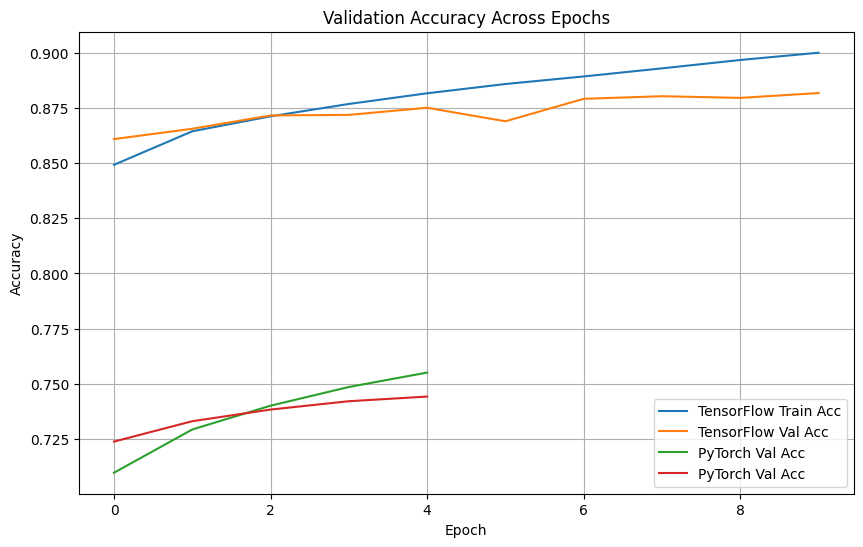

In [28]:
# TensorFlow metrics
tf_train_loss = history.history['loss']
tf_val_loss = history.history['val_loss']
tf_train_acc = history.history['accuracy']
tf_val_acc = history.history['val_accuracy']

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(tf_train_acc, label='TensorFlow Train Acc')
plt.plot(tf_val_acc, label='TensorFlow Val Acc')
plt.plot(train_accuracies, label='PyTorch Val Acc')
plt.plot(val_accuracies, label='PyTorch Val Acc')
plt.title("Validation Accuracy Across Epochs")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.show()

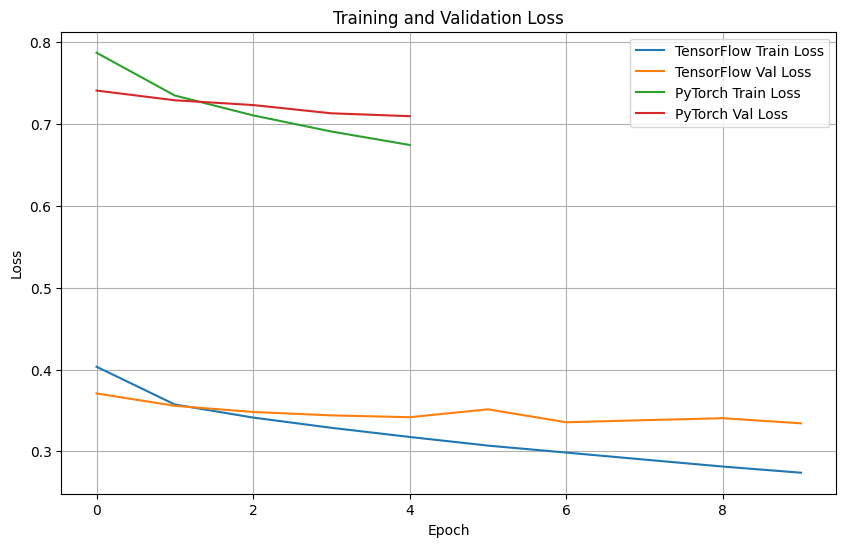

In [29]:
# Plot Losses
plt.figure(figsize=(10, 6))
plt.plot(tf_train_loss, label='TensorFlow Train Loss')
plt.plot(tf_val_loss, label='TensorFlow Val Loss')
plt.plot(train_losses, label='PyTorch Train Loss')
plt.plot(val_losses, label='PyTorch Val Loss')
plt.title("Training and Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()

In [30]:
# Final epoch metrics
performance_metrics = {
    "Model": ["VADER", "TensorFlow", "PyTorch"],
    "Final Val Accuracy": [vader_accuracy, tf_val_acc[-1], val_accuracies[-1]],
    "Final Val Loss": ["-", tf_val_loss[-1], val_losses[-1]],
    "Final Train Loss": ["-", tf_train_loss[-1], train_losses[-1]],
}

performance_df = pd.DataFrame(performance_metrics)
performance_df

,Model,Final Val Accuracy,Final Val Loss,Final Train Loss
0,VADER,0.795623,-,-
1,TensorFlow,0.881854,0.33424,0.273883
2,PyTorch,0.744175,0.709715,0.67453


# THE END!!!

### Future update.
- Train the models on the entire dataset.
- Build a system to rate online amazon reviews.